<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>

</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>
<!-- <font face="Times New Roman" size=4>
Deadline:
</font> -->
<hr>
</div></font>

name = ""

studentId = ""

It is recommended to open this notebook in Google Colab from [here](https://colab.research.google.com/drive/1oRa8tpMWx52pxfydpwQloKIYseZOA-z2?usp=sharing) and create a copy. You can comment your questions on the notebook as well.

In this exercise we want to gain hands-on experience with Normalizing Flow Models.
1. We want to implement simple flow models from scratch. (GPU not required)
2. We will use a flow model to perform image in-painting. (GPU recommended)

# Section 1: Flow From Scratch

In [30]:
# @title imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm import tqdm
import numpy as np

import time

In [31]:
# @title settings
# @title settings

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Transforms

One of the challenges in creating flow models is creating **invertible** transformations with computable **Jacobian determinant**. We will create such transformations now.

In [32]:
# @title Base Transform classes / helpers

class InverseNotAvailable(Exception):
    pass

class Transform(nn.Module):
    """Base class for invertible transform objects.

    Every transform.forward returns (y, log_det_J) where log_det_J is a tensor
    shaped (batch,) or a scalar (will be broadcasted).
    inverse(...) should return the inverse mapping (no log-det returned).
    """
    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise InverseNotAvailable()

First lets create a permutation transform

In [ ]:
class PermutationTransform(Transform):
    def __init__(self, num_features, permutation=None):
        super().__init__()
        if permutation is None:
            permutation = torch.randperm(num_features)
        else:
            permutation = torch.as_tensor(permutation, dtype=torch.long)

        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        # TODO: apply permutation to input
        # return permuted_x, log_det (which is zero)
        permuted_x = inputs[:, self.permutation]
        log_det = torch.zeros(inputs.shape[0], device=inputs.device)
        return permuted_x, log_det

    def inverse(self, inputs, context=None):
        # TODO: apply inverse permutation
        return inputs[:, self.inverse_permutation]

Now create an ActNorm Transform. Learnable per-channel scale & bias with data-dependent init

In [ ]:
class ActNorm(Transform):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features

        # scale and bias are learned per feature
        # TODO: create learnable bias and log_scale parameters
        # HINT: nn.Parameter with shape (1, num_features)
        self.bias = nn.Parameter(torch.zeros(1, num_features))
        self.log_scale = nn.Parameter(torch.zeros(1, num_features))

        self.initialized = False

    def forward(self, x, context=None):
        # Data-dependent initialization (first batch)
        if (not self.initialized) and self.training:
            # compute per-feature mean/std over batch
            # On first batch during training:
            #   - compute mean and std over batch
            #   - initialize bias and log_scale using affine normalization rule

            with torch.no_grad():
                # set bias and log_scale so that output has zero mean/unit var
                batch_mean = torch.mean(x, dim=0, keepdim=True)
                batch_std = torch.std(x, dim=0, keepdim=True) + 1e-6
                self.bias.data.copy_(-batch_mean)
                self.log_scale.data.copy_(-torch.log(batch_std))

            self.initialized = True

        # TODO: apply ActNorm transformation:
        #   y = (x + bias) * exp(log_scale)

        # TODO: compute log-det per sample (sum over features of log_scale)
        y = (x + self.bias) * torch.exp(self.log_scale)
        
        log_det = torch.sum(self.log_scale) * torch.ones(x.shape[0], device=x.device)

        return y, log_det

    def inverse(self, y, context=None):
        # TODO: implement inverse transformation
        x = y * torch.exp(-self.log_scale) - self.bias
        return x

Create an invertible linear (dense) layer with orthogonal / LU parametrization. Inspired by the 1x1 convolution used in Glow.

In [ ]:
class InvertibleLinear(Transform):
    """
    Learnable invertible linear transform for vectors (analogue of 1x1 conv).
    If use_lu=True, uses LU decomposition for fast invertibility & log-det.
    """
    def __init__(self, num_features, use_lu=False):
        super().__init__()
        self.num_features = num_features
        self.use_lu = use_lu

        # ---- Option 1: Full matrix (default) ----
        if not use_lu:
            # TODO: initialize a random orthogonal matrix q using QR decomposition
            w_init = torch.randn(num_features, num_features)
            q, _ = torch.linalg.qr(w_init)
            # store as nn.Parameter
            self.weight = nn.Parameter(q)
            return

        # ---- Option 2: LU parameterization ----
        # Initialize a random orthogonal matrix
        w_init = torch.randn(num_features, num_features)
        q, _ = torch.linalg.qr(w_init)

        # Get LU decomposition
        P, L, U = torch.linalg.lu(q)

        # Store permutation matrix P as buffer
        self.register_buffer("P", P)

        # Mask for L: strictly lower part + identity diagonal (HINT: use torch.tril)
        L_mask = torch.tril(torch.ones_like(q), diagonal=-1)
        self.register_buffer("L_mask", L_mask)

        # Mask for U: upper triangular including diagonal (HINT: use torch.triu)
        U_mask = torch.triu(torch.ones_like(q), diagonal=0)
        self.register_buffer("U_mask", U_mask)

        # Create learnable parameters for L and U
        self.L_params = nn.Parameter(L * L_mask)  # strictly lower triangle
        self.U_params = nn.Parameter(U * U_mask)  # upper triangle

        # Store diagonal separately for log-det
        self.log_diag_U = nn.Parameter(torch.log(torch.abs(torch.diag(U)) + 1e-6))

    def _assemble_weight(self):
        """Reconstruct weight matrix W = P @ L @ U from LU params."""
        if not self.use_lu:
            return self.weight

        # Reconstruct L: fill lower part + identity diagonal
        eye = torch.eye(self.num_features, device=self.L_params.device)
        L = self.L_params * self.L_mask + eye

        # Reconstruct U: fill upper triangle but use exp(log_diag_U) for diagonal
        U = self.U_params * self.U_mask
        diag_U = torch.diag(torch.exp(self.log_diag_U))
        U_no_diag = torch.triu(U, diagonal=1)
        U = U_no_diag + diag_U

        # Final weight
        W = self.P @ L @ U
        return W

    def forward(self, x, context=None):
        W = self._assemble_weight()

        y = x @ W.t()

        if self.use_lu:
            log_det = torch.sum(self.log_diag_U)
            log_det = log_det * torch.ones(x.size(0), device=x.device)
        else:
            sign, logabsdet = torch.slogdet(W)
            log_det = logabsdet * torch.ones(x.size(0), device=x.device)

        return y, log_det

    def inverse(self, y, context=None):
        W = self._assemble_weight()
        W_inv = torch.inverse(W)  # could also do LU solve if needed
        return y @ W_inv.t()

Now  lets create a simple Affine Coupling Transform. From RealNVP.

$$y_d = x_d * \exp(s(x_a)) + t(x_a)$$

In [ ]:
# Coupling Transform
class AffineCouplingTransform(Transform):
    def __init__(self, mask, hidden_dims = 128, s_net_f=None, t_net_f=None):
        """
        Args:
            mask: a 1-dim tensor, tuple or list. It indexes inputs as follows:
                * If `mask[i] > 0`, `input[i]` will be transformed.
                * If `mask[i] <= 0`, `input[i]` will be passed unchanged.
            hidden_dims: Number of hidden units in the coupling networks.
        """
        super().__init__()

        mask = torch.as_tensor(mask, dtype=torch.float32)
        if mask.dim() != 1:
            raise ValueError("Mask must be a 1-dim tensor.")
        if mask.numel() <= 0:
            raise ValueError("Mask can't be empty.")

        self.register_buffer('mask', mask)
        self.num_features = self.mask.numel()

        # indices
        features_vector = torch.arange(self.num_features)
        self.identity_idx = features_vector[self.mask <= 0]
        self.transform_idx = features_vector[self.mask > 0]

        in_dim = len(self.identity_idx)
        out_dim = len(self.transform_idx)

        # small network factories
        if s_net_f is None:
            self.s = self._net(in_dim, out_dim, hidden_dims)
        else:
            self.s = s_net_f(in_dim, out_dim, hidden_dims)
        if t_net_f is None:
            self.t = self._net(in_dim, out_dim, hidden_dims)
        else:
            self.t = t_net_f(in_dim, out_dim, hidden_dims)

        # (Optional) initialize last layer of s and t to zeros for stable initial transforms

    def _net(self, input_dim, output_dim, hidden_dims):
        # TODO: Implement small MLPs s() and t()
        # Suggested architecture: Linear → ReLU → Linear → ReLU → Linear
        net = nn.Sequential(
            nn.Linear(input_dim, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dim)
        )
        return net

    def forward(self, x, context=None):
        if x.dim() != 2:
            raise ValueError("Expect 2D inputs")

        # TODO: split x into x_id and x_tr
        x_id = x[:, self.identity_idx]
        x_tr = x[:, self.transform_idx]

        # TODO: compute s(x_id) and t(x_id)
          # HINT: apply tanh to s() and multiply by 2.0
          # (Optional) constrain s lightly to avoid huge scale initially (scale range roughly (-2,2))
        s = self.s(x_id)
        t = self.t(x_id)
        s = torch.tanh(s) * 2.0

        # TODO: compute transformed output y
        y_tr = x_tr * torch.exp(s) + t

        # TODO: compute transformed output y
        y = torch.zeros_like(x)
        y[:, self.identity_idx] = x_id
        y[:, self.transform_idx] = y_tr

        # TODO: compute log-det = sum of s over transform dims
        log_det = torch.sum(s, dim=1)

        return y, log_det

    def inverse(self, y, context=None):
        # TODO: implement inverse coupling equation
        y_id = y[:, self.identity_idx]
        y_tr = y[:, self.transform_idx]

        s = self.s(y_id)
        t = self.t(y_id)
        s = torch.tanh(s) * 2.0

        x_tr = (y_tr - t) * torch.exp(-s)

        x = torch.zeros_like(y)
        x[:, self.identity_idx] = y_id
        x[:, self.transform_idx] = x_tr

        return x

## Model

In this step we implement a simple Normalizing Flow model (RealNVP-like).
The model consists of:
  - a sequence of invertible transforms
  - a base Gaussian distribution
The Flow class is generic: it can (mostly) work with any sequence of invertible transforms.

In [ ]:
# Flow Container
class Flow(nn.Module):
    def __init__(self, transforms, base_distribution=None):
        super(Flow, self).__init__()
        self.transforms = nn.ModuleList(transforms).to(device)
        self.num_features = self.transforms[0].num_features
        if base_distribution is None:
            self.base_distribution = D.MultivariateNormal(
                loc=torch.zeros(self.num_features, device=device),
                covariance_matrix=torch.eye(self.num_features, device=device)
            )
        else:
            self.base_distribution = base_distribution

    def forward(self, x):
        """
        Forward pass through the flow:
        x → z
        Returns:
            z: latent variable
            log_det_total: total log determinant (batch,)
        """

        # TODO: initialize log_det_total
        log_det_total = torch.zeros(x.shape[0], device=x.device)
        z = x

        # TODO: loop through transforms, applying forward()
        # TODO: accumulate log-det per transform
        for t in self.transforms:
            z, log_det = t(z)
            log_det_total += log_det

        return z, log_det_total


    def inverse(self, z):
        """
        Inverse pass through the flow:
        z → x
        (uses inverse() of transforms in reverse order)
        """
        x = z
        # TODO: loop backwards through transforms applying inverse()
        for t in reversed(self.transforms):
            x = t.inverse(x)
        return x

    def log_prob(self, x):
        """
        Computes and returns log p(x) = log p(z) + log|det J|
        """
        # TODO: compute z and log_det_J via forward(...)
        z, log_det = self.forward(x)

        # TODO: compute log_prob under base distribution (HINT: self.base_distribution.log_prob(z) )
        log_prob_base = self.base_distribution.log_prob(z)

        return log_prob_base + log_det

    def sample(self, num_samples):
        """
        Sample from flow by sampling z ~ base and inverting.
        """
        # TODO: sample z from base distribution (HINT: self.base_distribution.sample(...) )
        z = self.base_distribution.sample((num_samples,))

        # TODO: invert z to x
        x = self.inverse(z)
        return x


    def sample_and_log_prob(self, num_samples):
        """
        Similar to sample(), but also returns log_prob.
        """
        # TODO: sample z
        
        # TODO: apply inverse to get x
        z = self.base_distribution.sample((num_samples,))
        # TODO: compute log_prob(z)
        log_prob_z = self.base_distribution.log_prob(z)

        # TODO: apply inverse to get x

        x = self.inverse(z)

        # TODO: recompute log-det by passing x through transforms again
        _, log_det_fwd = self.forward(x)

        return x, log_prob_z + log_det_fwd

Now  we initialize the model and coupling layers. We then train the model on the simple Moons dataset and visualize its learning process through its latent space.

In [38]:
# Mask helper
def make_masks(num_features, alternating=True):
    if alternating:
        return [(i % 2) for i in range(num_features)]
    else:
        return [((i+1) % 2) for i in range(num_features)]

In [ ]:
def build_realnvp_flow(num_features=2, n_couplings=6, hidden_dims=128):
    transforms = []

    # TODO: Start with ActNorm
    transforms.append(ActNorm(num_features))

    for i in range(n_couplings):
        # TODO: create alternating mask using make_masks()
        mask = make_masks(num_features, alternating=(i % 2 == 0))

        # TODO: append AffineCouplingTransform
        transforms.append(AffineCouplingTransform(mask, hidden_dims=hidden_dims))

        # TODO: append an InvertibleLinear layer
        #   Suggestion: alternate use_lu = (i % 2 == 0)
        transforms.append(InvertibleLinear(num_features, use_lu=(i % 2 == 0)))

    # TODO: return Flow(transforms)
    return Flow(transforms).to(device)

def build_permut_flow(num_features=2, n_couplings=6, hidden_dims=128):
    transforms = []

    # TODO: Start with ActNorm
    transforms.append(ActNorm(num_features))

    for i in range(n_couplings):
        # TODO: alternating mask
        
        mask = make_masks(num_features, alternating=(i % 2 == 0))

        # TODO: add AffineCouplingTransform
        transforms.append(AffineCouplingTransform(mask, hidden_dims=hidden_dims))

        # TODO: add a random PermutationTransform each time
        transforms.append(PermutationTransform(num_features))

    # TODO: return Flow(transforms)
    return Flow(transforms).to(device)

In [ ]:
# ======= Small training loop on make_moons =======
def train_flow(flow,
              X,
              num_epochs=1000,
              batch_size=256,
              lr=1e-3,
              log_interval=50,
              verbose=True):
    """
    Train a given Flow instance on data X (torch tensor on device).
    Returns: (trained_flow, loss_history)
    """
    flow = flow.to(device)
    opt = optim.Adam(flow.parameters(), lr=lr)
    dataset = torch.utils.data.TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    loss_history = []
    pbar = tqdm(range(num_epochs), disable=not verbose)

    for epoch in pbar:
        epoch_loss = 0.0

        for (batch,) in loader:
            # TODO: zero gradients
            opt.zero_grad()

            # TODO: compute NLL = -flow.log_prob(batch)
            log_prob = flow.log_prob(batch)
            loss = -torch.mean(log_prob)

            # TODO: backward & step
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        # TODO: compute average epoch loss
        epoch_loss /= len(loader)
        loss_history.append(epoch_loss)

        if verbose and (epoch % log_interval == 0 or epoch == num_epochs-1):
            pbar.set_description(f"Epoch {epoch} loss {loss_history[-1]:.4f}")

            if epoch % (log_interval * 5) and X.shape[1] == 2:
                with torch.no_grad():
                    xline = torch.linspace(-1.5, 2.5, 200, device=device)
                    yline = torch.linspace(-0.75, 1.25, 200, device=device)
                    xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')

                    xy = torch.stack([xgrid.flatten(), ygrid.flatten()], dim=1)

                    log_prob_grid = flow.log_prob(xy)
                    zgrid = torch.exp(log_prob_grid).reshape(200, 200).cpu()

                plt.figure(figsize=(8, 6))
                plt.contourf(
                    xgrid.cpu().numpy(),
                    ygrid.cpu().numpy(),
                    zgrid.numpy(),
                    levels=50,
                    cmap='viridis'
                )
                plt.title(f"Epoch {epoch}")
                plt.xlabel('x1')
                plt.ylabel('x2')
                plt.colorbar(label='Density')
                plt.show()

    return flow, loss_history

## Training and Evaluation

In this step you will:
  - Train two types of flows on the make_moons dataset
  - Compare their training losses
  - Visualize density contours
  - Visualize generated samples


You are encouraged to add your own configurations and their names to `flow_names` and find better results.

You may **slightly** modify the visualization codes to match your code but this is discouraged.



=== Building & training flow: RealNVP ===


Epoch 50 loss 0.9575:   5%|▌         | 50/1000 [00:09<03:36,  4.39it/s]

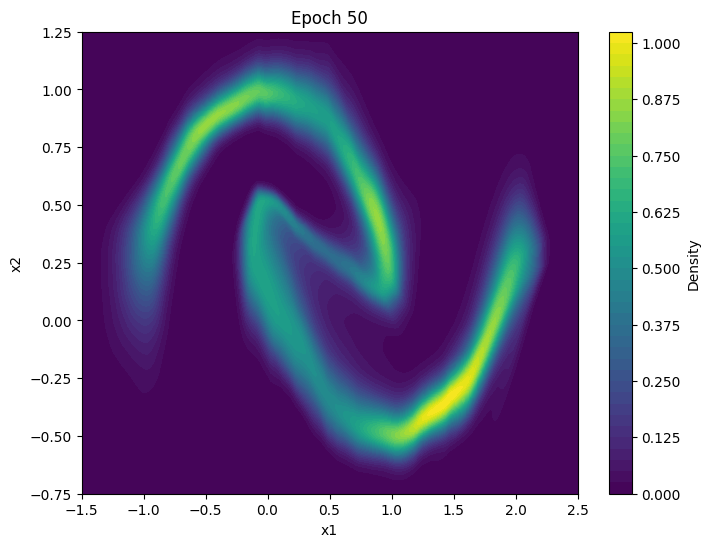

Epoch 100 loss 0.8765:  10%|█         | 100/1000 [00:18<03:21,  4.47it/s]

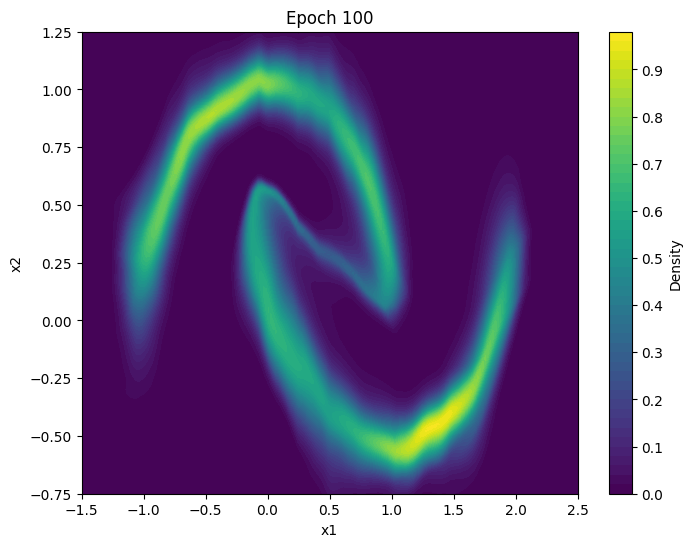

Epoch 150 loss 0.8564:  15%|█▌        | 150/1000 [00:27<02:17,  6.20it/s]

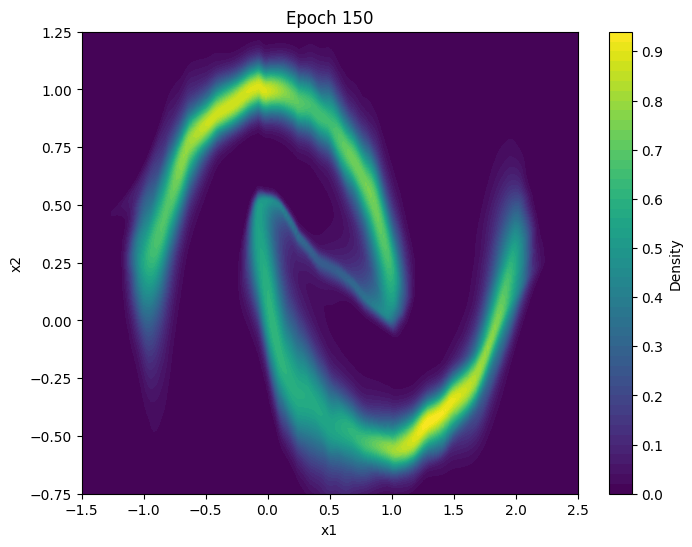

Epoch 200 loss 0.8603:  20%|██        | 200/1000 [00:38<02:13,  6.01it/s]

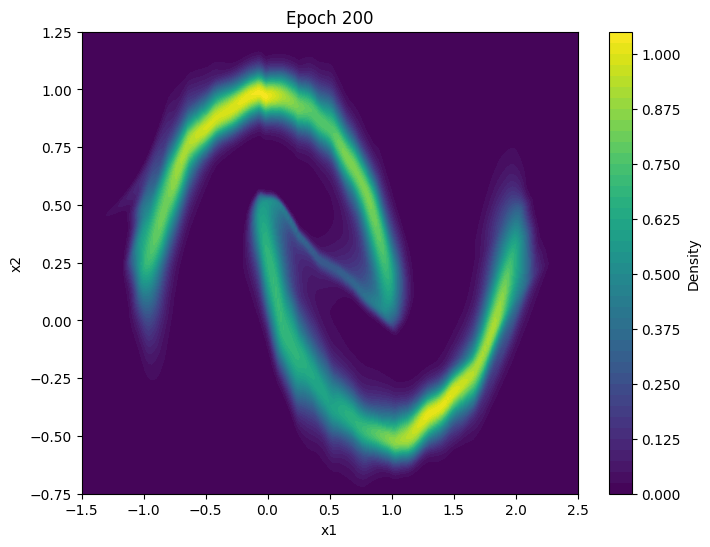

Epoch 300 loss 0.8338:  30%|███       | 300/1000 [00:55<01:51,  6.25it/s]

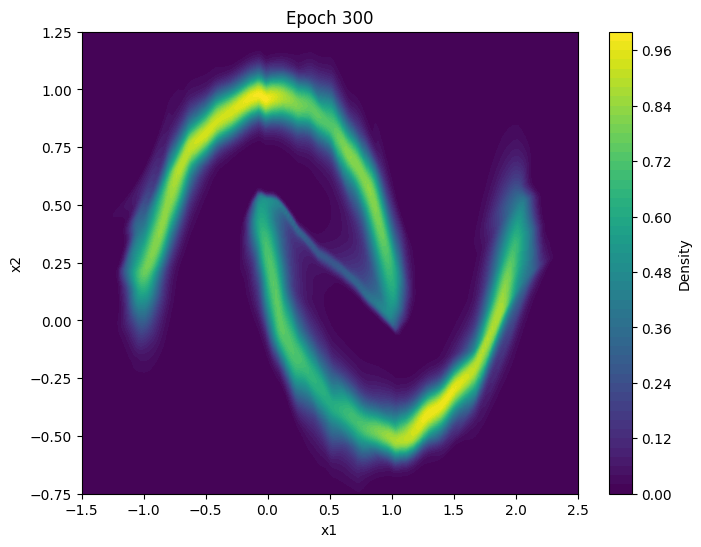

Epoch 350 loss 0.8407:  35%|███▌      | 350/1000 [01:04<01:44,  6.24it/s]

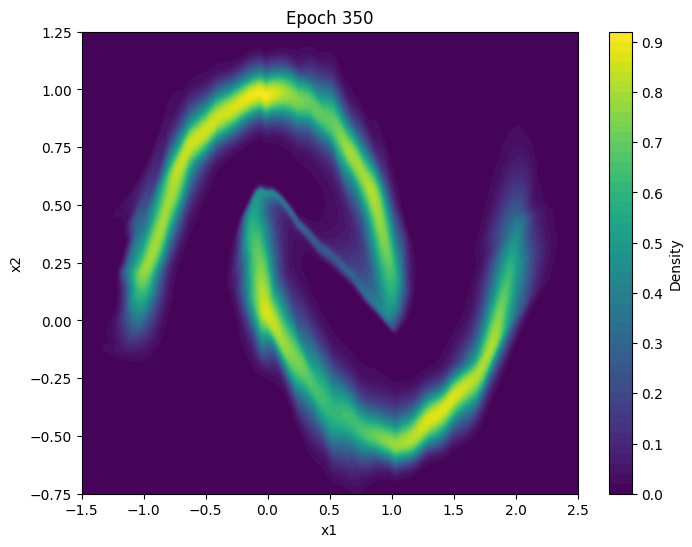

Epoch 400 loss 0.8412:  40%|████      | 400/1000 [01:13<01:37,  6.14it/s]

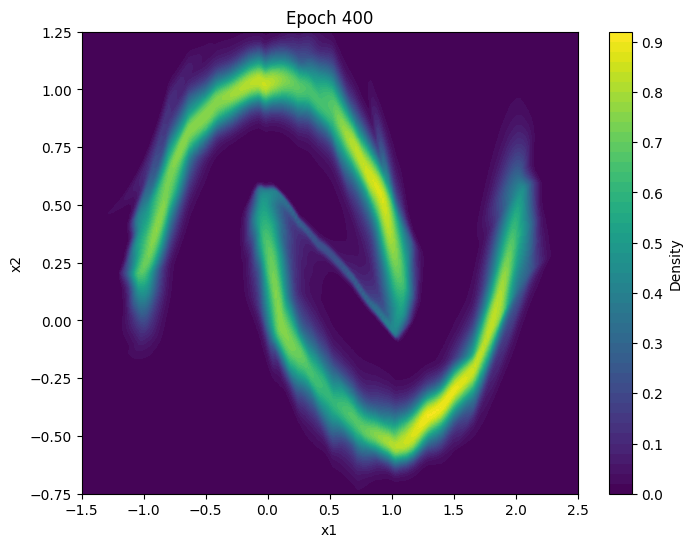

Epoch 450 loss 0.8399:  45%|████▌     | 450/1000 [01:23<01:39,  5.51it/s]

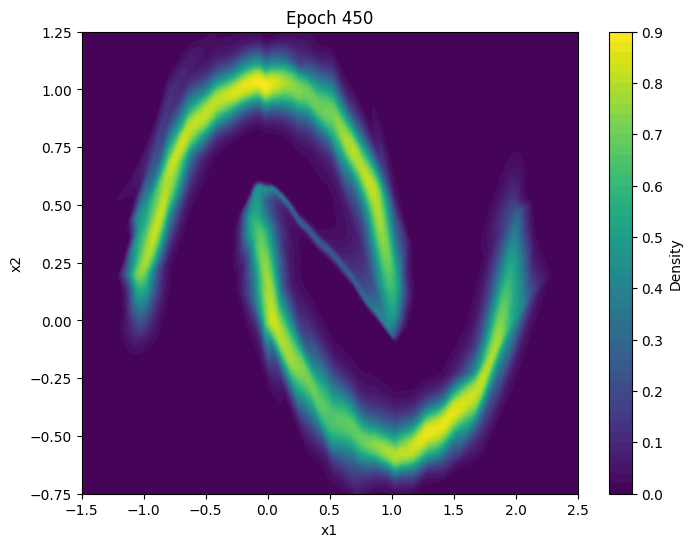

Epoch 550 loss 0.8116:  55%|█████▌    | 550/1000 [01:40<01:13,  6.15it/s]

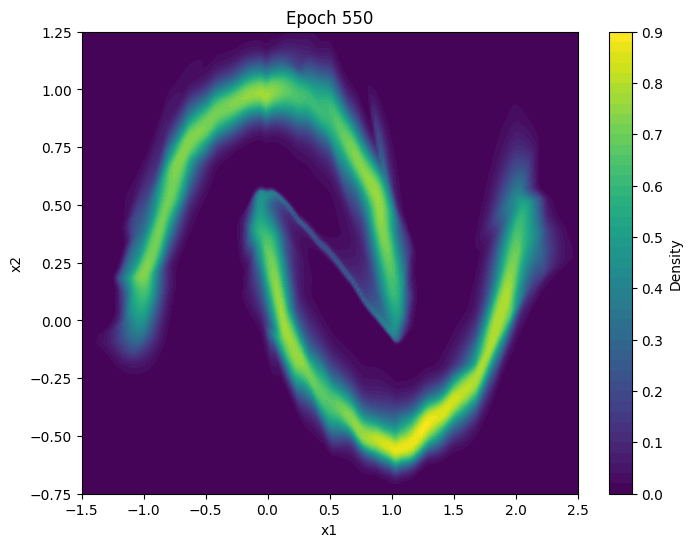

Epoch 600 loss 0.8121:  60%|██████    | 600/1000 [01:49<01:04,  6.20it/s]

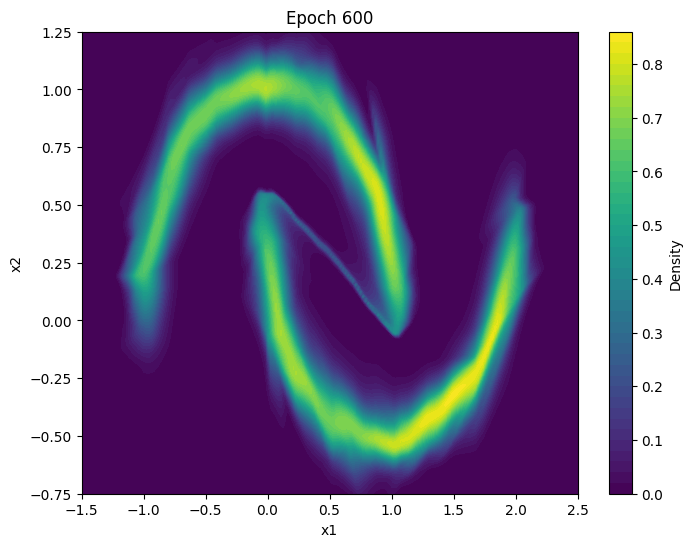

Epoch 650 loss 0.7677:  65%|██████▌   | 650/1000 [01:58<01:17,  4.50it/s]

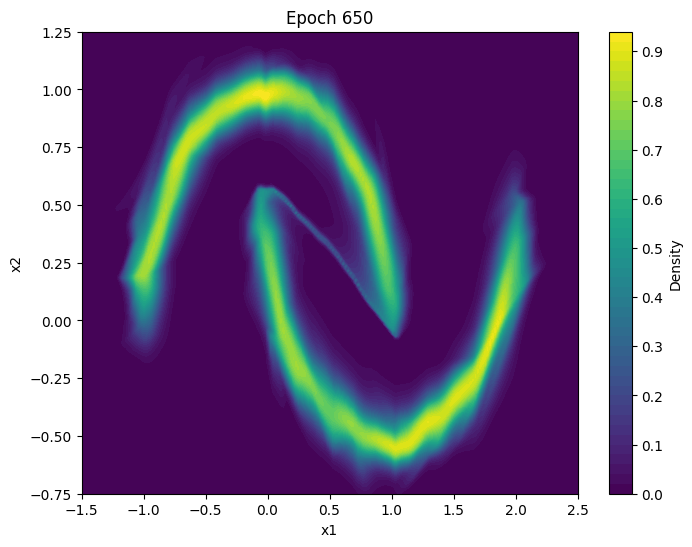

Epoch 700 loss 0.7983:  70%|███████   | 700/1000 [02:07<00:48,  6.22it/s]

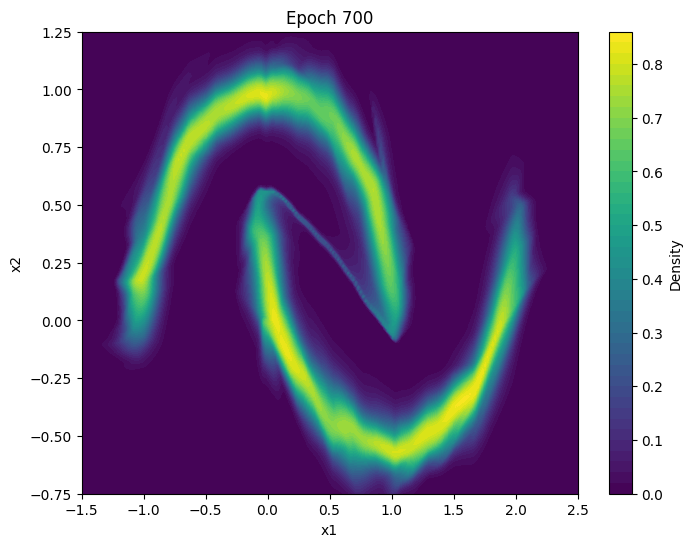

Epoch 800 loss 0.7909:  80%|████████  | 800/1000 [02:25<00:33,  6.01it/s]

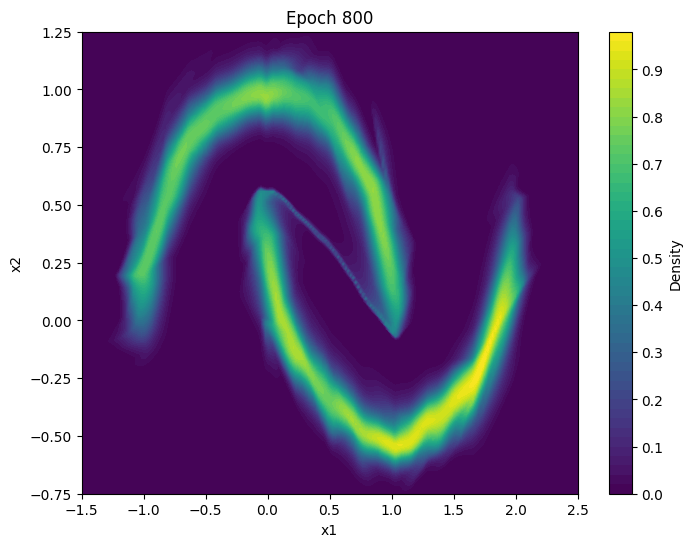

Epoch 850 loss 0.8027:  85%|████████▌ | 850/1000 [02:34<00:35,  4.26it/s]

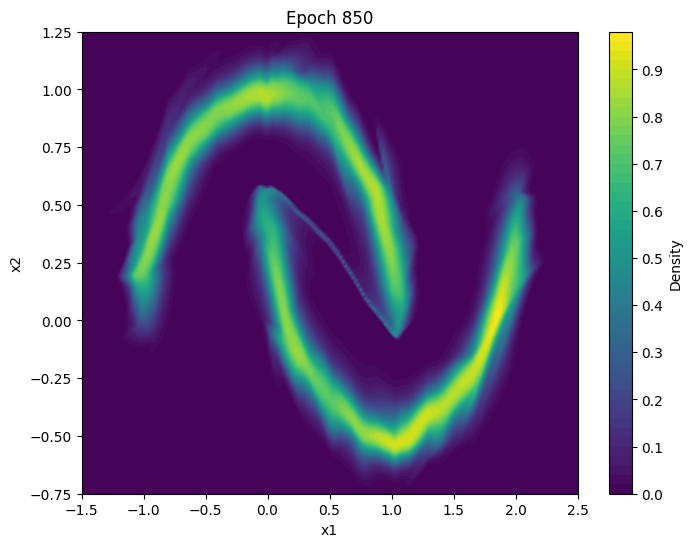

Epoch 900 loss 0.7711:  90%|█████████ | 900/1000 [02:43<00:16,  5.92it/s]

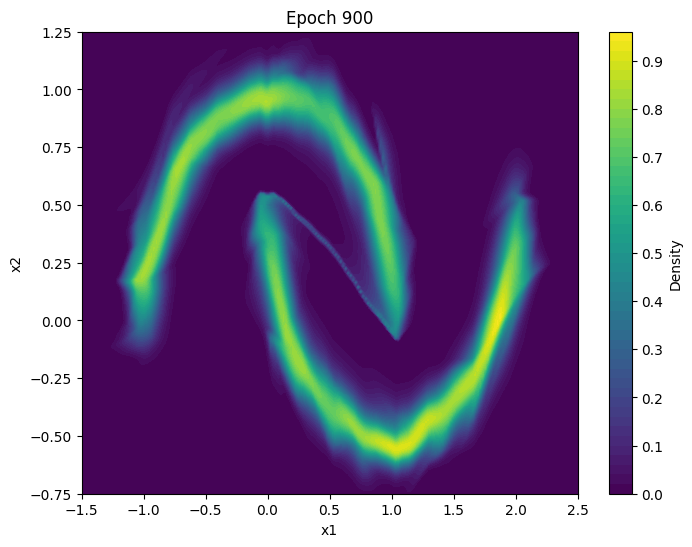

Epoch 950 loss 0.7798:  95%|█████████▌| 950/1000 [02:53<00:08,  5.97it/s]

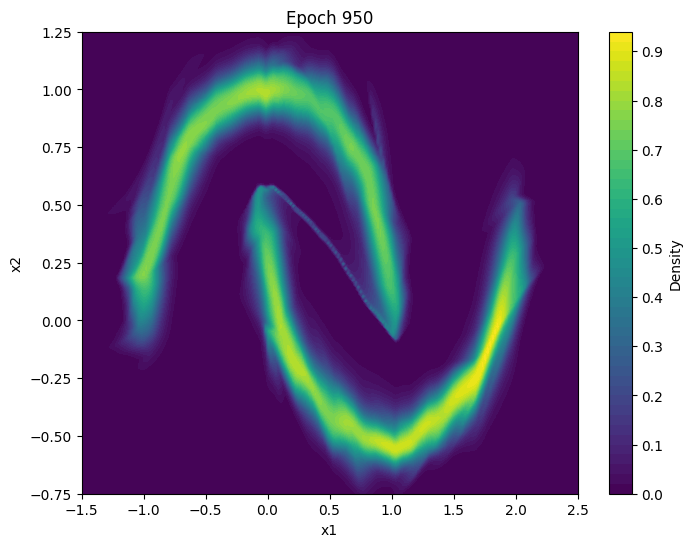

Epoch 999 loss 0.7759: 100%|█████████▉| 999/1000 [03:02<00:00,  5.88it/s]

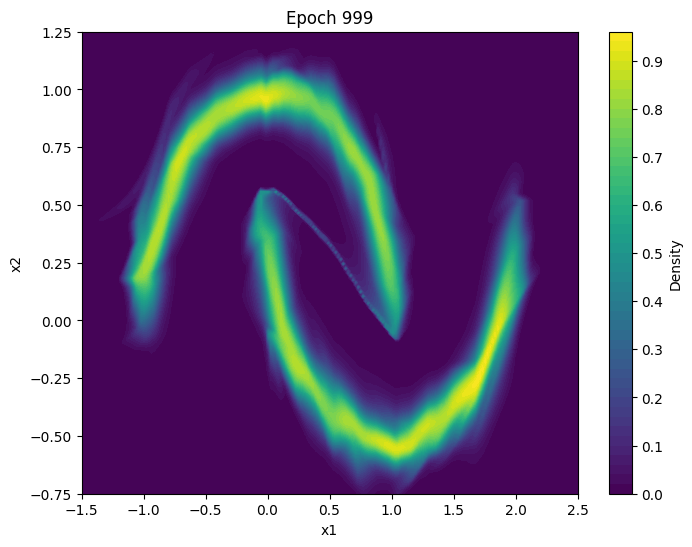

Epoch 999 loss 0.7759: 100%|██████████| 1000/1000 [03:02<00:00,  5.48it/s]


Trained RealNVP in 182.5s; final loss 0.7759


=== Building & training flow: PermutFlow ===


Epoch 50 loss 1.1391:   5%|▌         | 50/1000 [00:07<03:03,  5.19it/s]

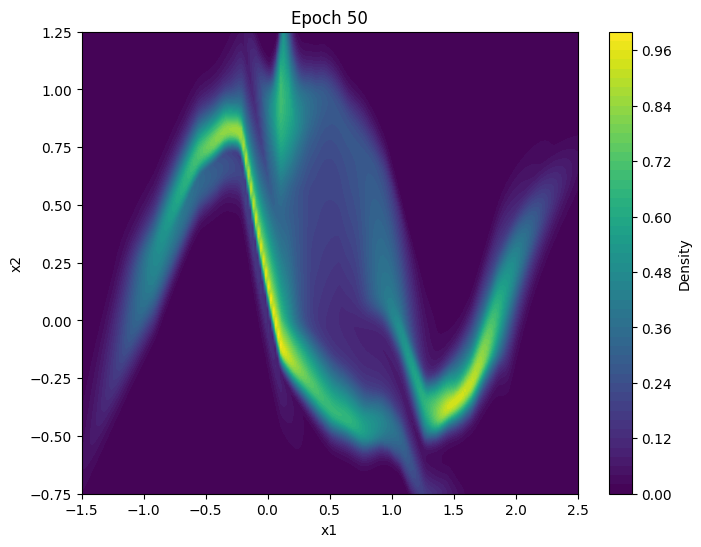

Epoch 100 loss 1.0702:  10%|█         | 100/1000 [00:15<02:08,  7.00it/s]

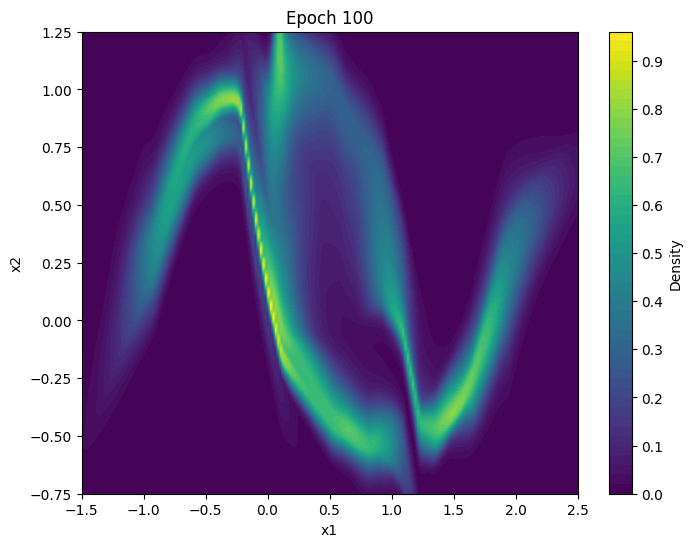

Epoch 150 loss 1.0853:  15%|█▌        | 150/1000 [00:24<02:03,  6.86it/s]

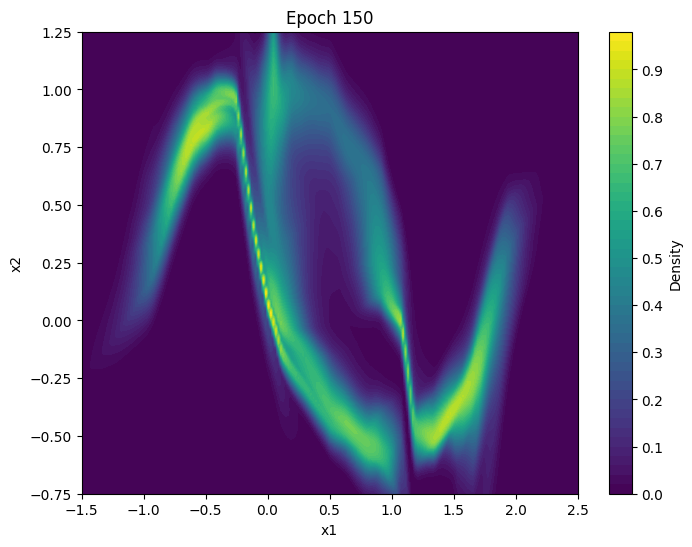

Epoch 200 loss 1.0167:  20%|██        | 200/1000 [00:31<02:19,  5.73it/s]

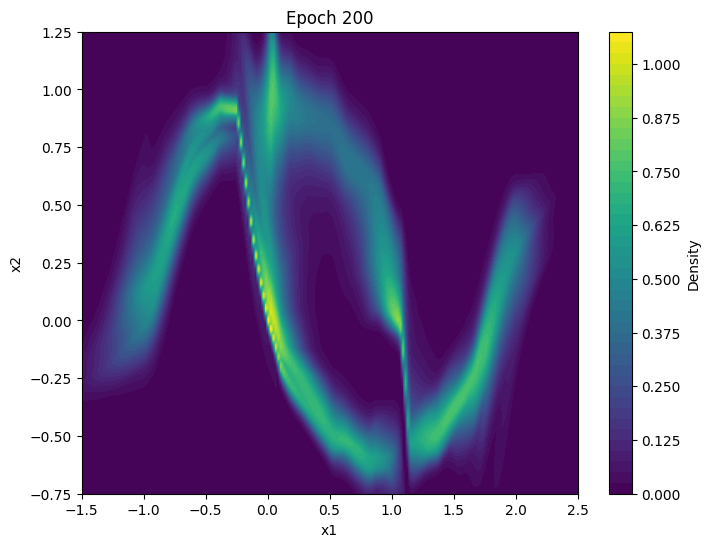

Epoch 300 loss 0.9813:  30%|███       | 300/1000 [00:48<01:40,  6.98it/s]

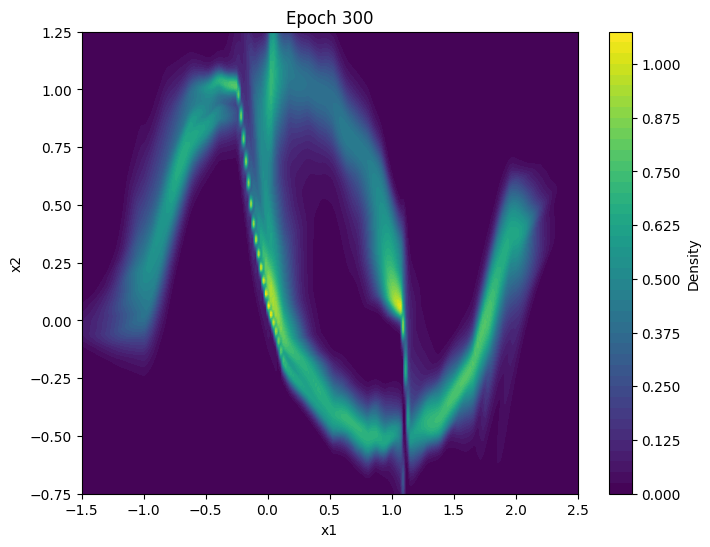

Epoch 350 loss 0.9427:  35%|███▌      | 350/1000 [00:55<01:32,  7.01it/s]

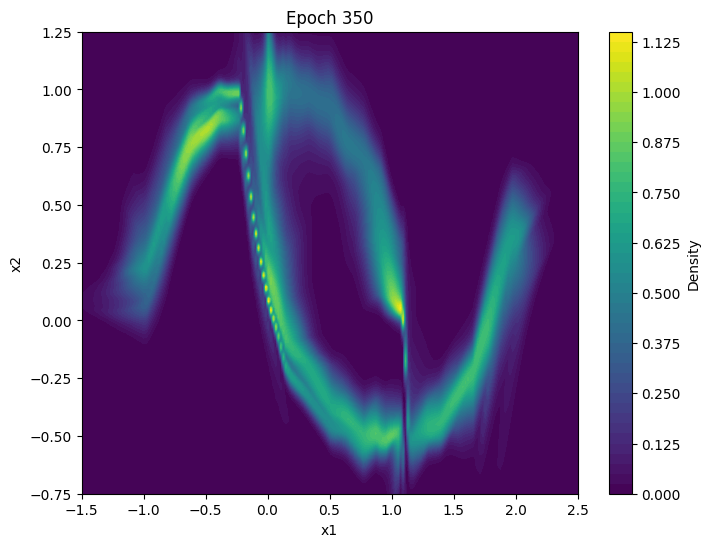

Epoch 400 loss 0.9509:  40%|████      | 400/1000 [01:03<01:26,  6.93it/s]

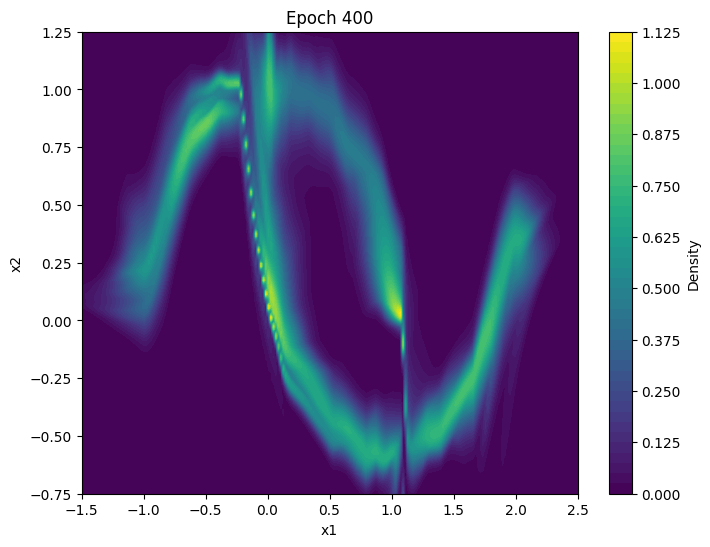

Epoch 450 loss 0.9601:  45%|████▌     | 450/1000 [01:12<01:21,  6.77it/s]

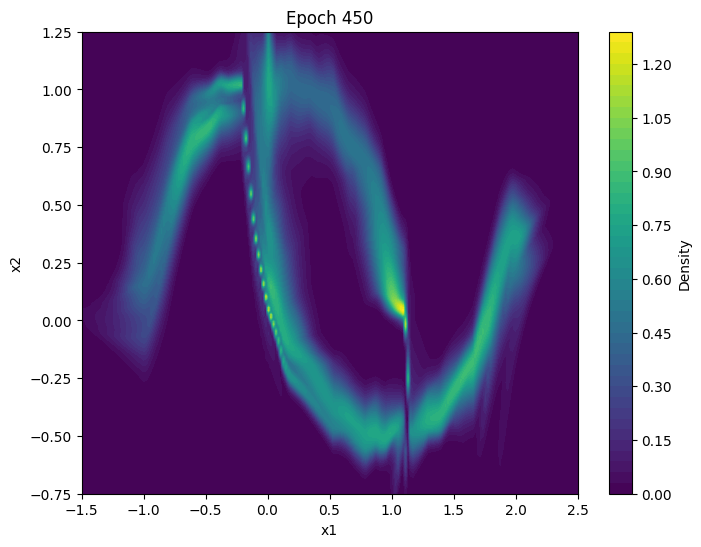

Epoch 550 loss 0.9252:  55%|█████▌    | 550/1000 [01:27<01:06,  6.74it/s]

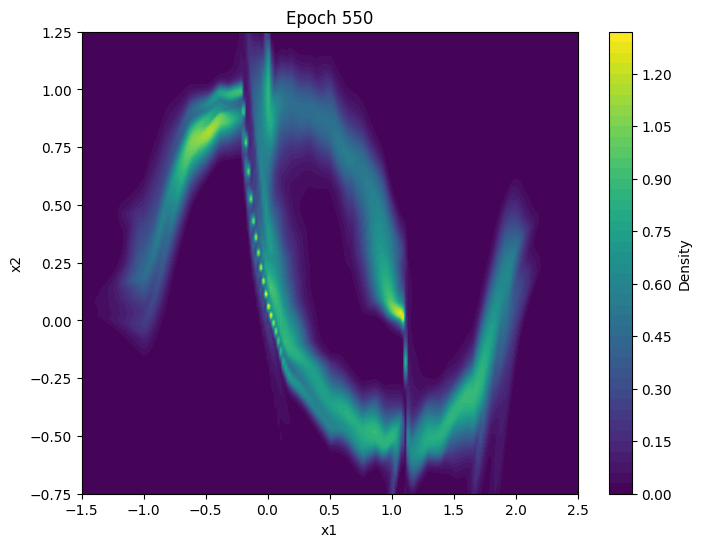

Epoch 600 loss 0.9140:  60%|██████    | 600/1000 [01:36<01:14,  5.36it/s]

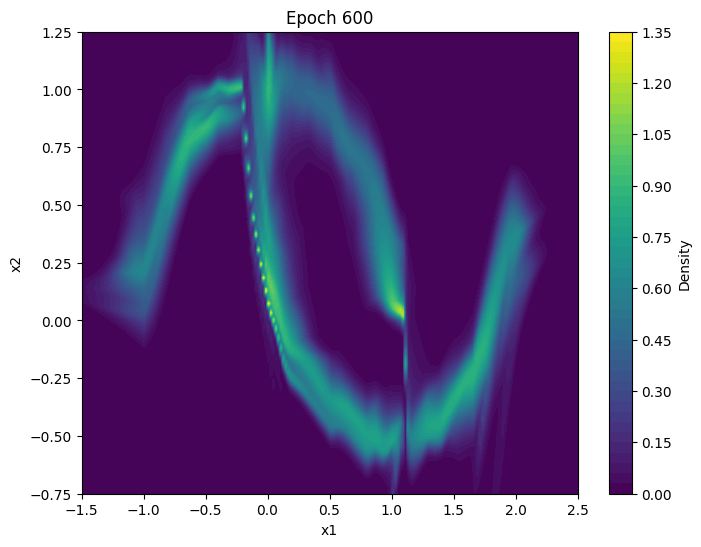

Epoch 650 loss 0.9386:  65%|██████▌   | 650/1000 [01:43<00:50,  6.98it/s]

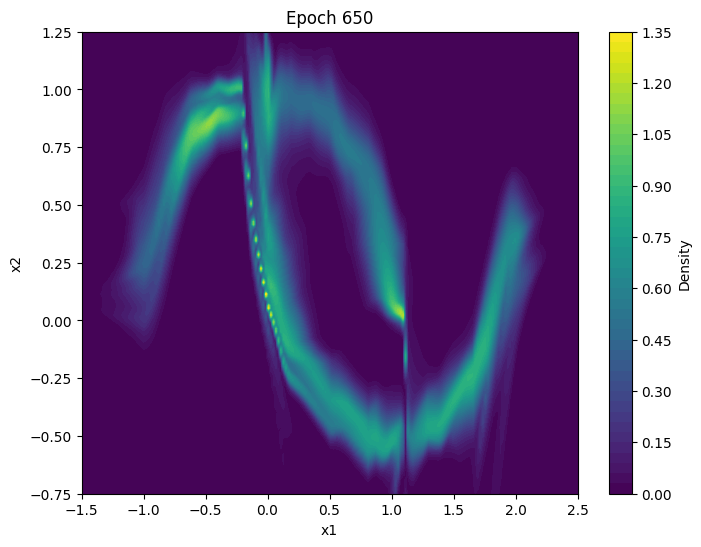

Epoch 700 loss 0.9172:  70%|███████   | 700/1000 [01:52<00:43,  6.95it/s]

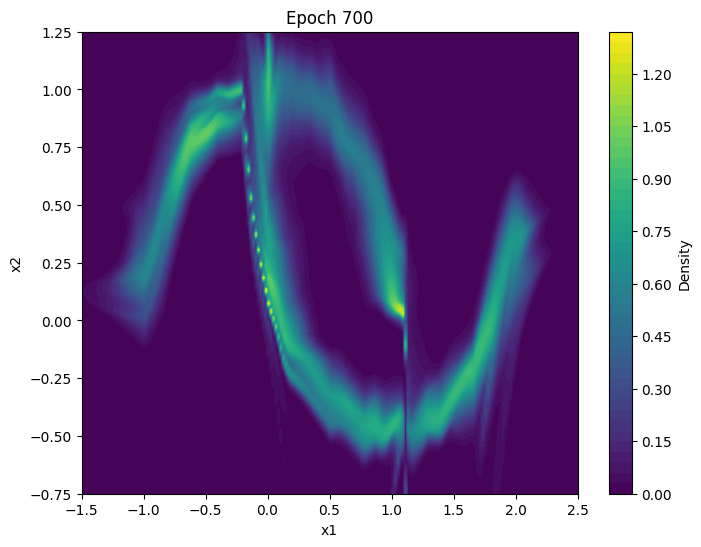

Epoch 800 loss 0.8822:  80%|████████  | 800/1000 [02:08<00:29,  6.77it/s]

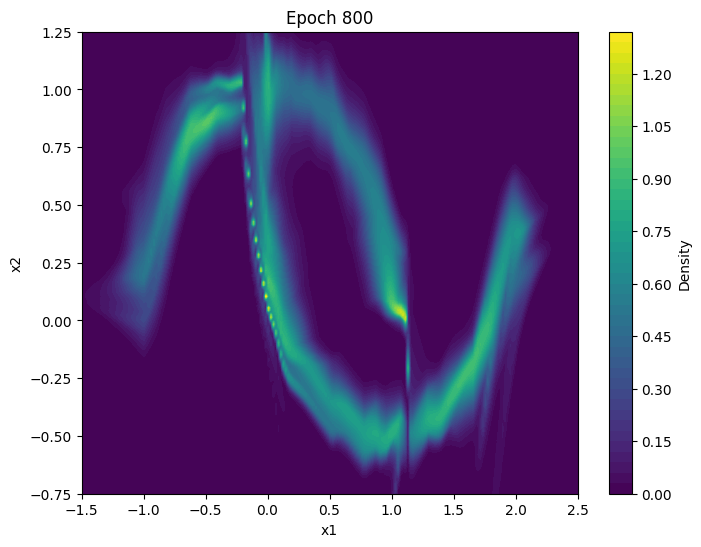

Epoch 850 loss 0.8931:  85%|████████▌ | 850/1000 [02:16<00:22,  6.70it/s]

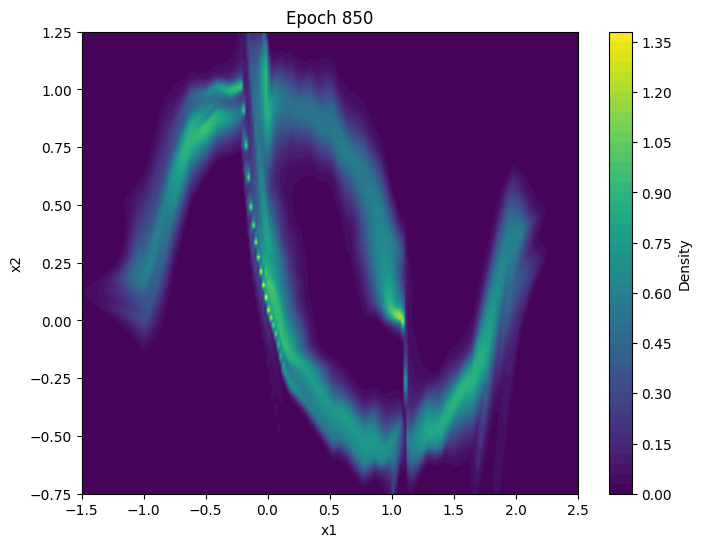

Epoch 900 loss 0.8829:  90%|█████████ | 900/1000 [02:24<00:18,  5.49it/s]

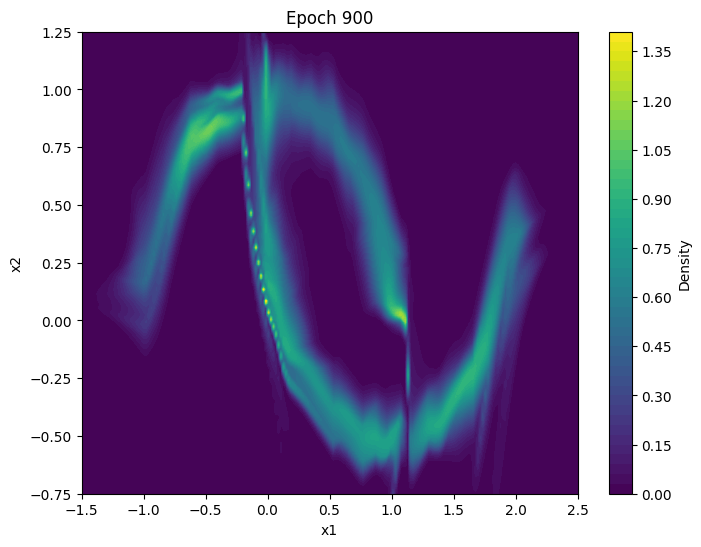

Epoch 950 loss 0.8924:  95%|█████████▌| 950/1000 [02:32<00:07,  6.86it/s]

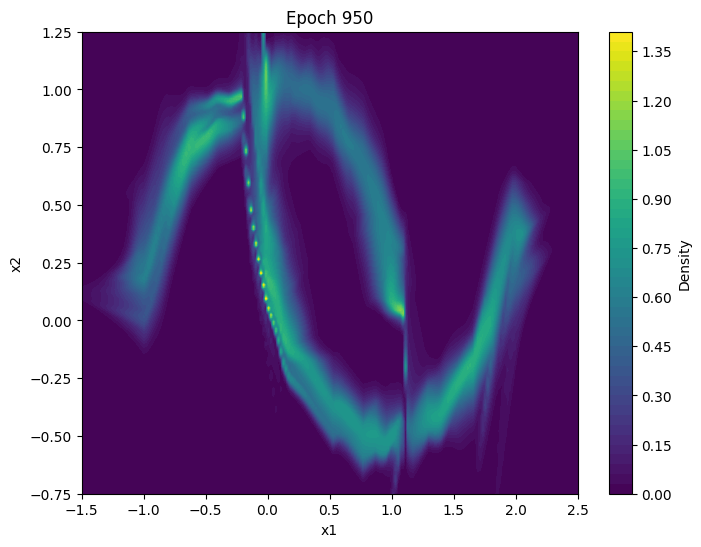

Epoch 999 loss 0.9006: 100%|█████████▉| 999/1000 [02:41<00:00,  6.86it/s]

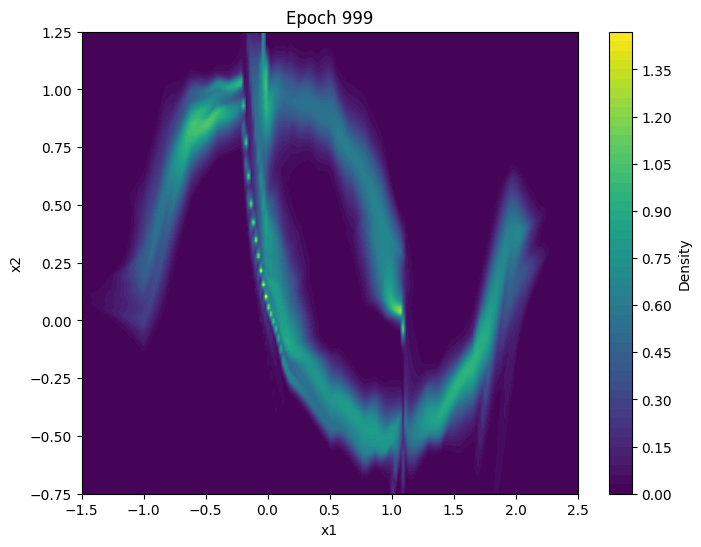

Epoch 999 loss 0.9006: 100%|██████████| 1000/1000 [02:41<00:00,  6.20it/s]

Trained PermutFlow in 161.3s; final loss 0.9006


In [41]:
# Hyperparameters
num_features = 2
hidden_dims = 128
batch_size = 256
learning_rate = 1e-3
num_epochs = 1000
n_couplings=6
num_samples_plot=1000
show_density=True

# Prepare data
X_np, _ = make_moons(n_samples=2000, noise=0.08, random_state=SEED)
X = torch.tensor(X_np, dtype=torch.float32).to(device)

results = {}
flow_names = ['RealNVP', 'PermutFlow']
for name in flow_names:
    print(f"\n========================================")
    print(f"\n=== Building & training flow: {name} ===")
    if name == 'RealNVP':
        flow = build_realnvp_flow(num_features=num_features, n_couplings=n_couplings, hidden_dims=hidden_dims)
    elif name == 'PermutFlow':
        flow = build_permut_flow(num_features=num_features, n_couplings=n_couplings, hidden_dims=hidden_dims)
    else:
        raise ValueError(f"Unknown flow name: {name}")

    start = time.time()
    trained_flow, losses = train_flow(flow, X,
                                      num_epochs=num_epochs,
                                      batch_size=batch_size,
                                      lr=learning_rate,
                                      log_interval=max(1, num_epochs//20),
                                      verbose=True)
    elapsed = time.time() - start
    print(f"Trained {name} in {elapsed:.1f}s; final loss {losses[-1]:.4f}")
    results[name] = {'flow': trained_flow, 'losses': losses}


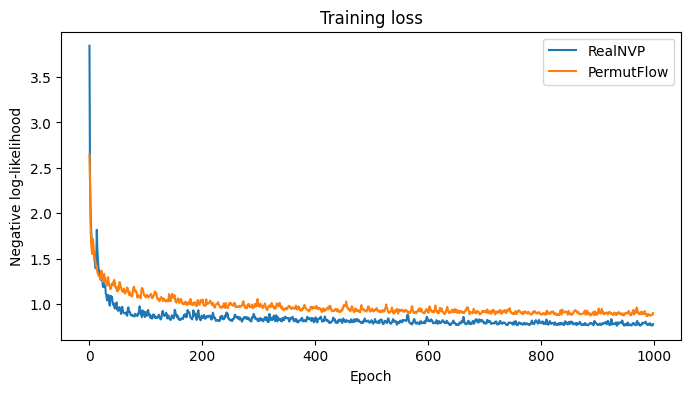

In [42]:
# Plotting training losses
plt.figure(figsize=(8,4))
for name, info in results.items():
    plt.plot(info['losses'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Negative log-likelihood')
plt.legend()
plt.title('Training loss')
plt.show()


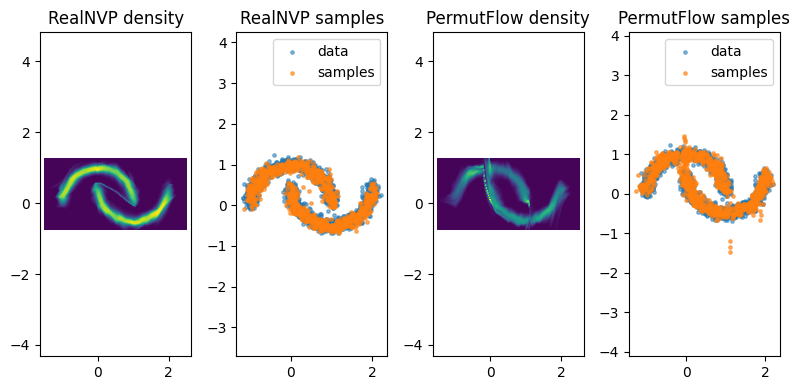

In [43]:
# Plot densities and samples for each model
xline = torch.linspace(-1.5, 2.5, 200, device=device)
yline = torch.linspace(-0.75, 1.25, 200, device=device)
xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
xy = torch.stack([xgrid.flatten(), ygrid.flatten()], dim=1).to(device)

n_variants = len(flow_names)
cols = min(3, n_variants)
rows = int(np.ceil(n_variants / cols))

plt.figure(figsize=(4*cols, 4*rows))
i = 1
for name in flow_names:
    info = results[name]
    f = info['flow']
    with torch.no_grad():
        logp = f.log_prob(xy)
        density = torch.exp(logp).reshape(xgrid.shape).cpu().numpy()
        samples = f.sample(num_samples_plot).cpu().numpy()

    # Density subplot
    plt.subplot(rows, cols*2, 2*(i-1)+1)
    if show_density:
        plt.contourf(xgrid.cpu().numpy(), ygrid.cpu().numpy(), density, levels=50)
        plt.title(f"{name} density")
        plt.axis('equal')
    else:
        plt.title(f"{name} density (hidden)")
        plt.axis('off')

    # Samples subplot
    plt.subplot(rows, cols*2, 2*(i-1)+2)
    plt.scatter(X.cpu().numpy()[:,0], X.cpu().numpy()[:,1], s=6, label='data', alpha=0.5)
    plt.scatter(samples[:,0], samples[:,1], s=6, label='samples', alpha=0.6)
    plt.title(f"{name} samples")
    plt.axis('equal')
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()

# Section 2: Image Inpainting

In [ ]:
!pip install normflows --quiet

In [ ]:
# Import required packages
import os
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torchvision as tv

import normflows as nf

In [ ]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
# Make CUDA deterministic *if* you want strict reproducibility (may be slower)
# torch.backends.cudnn.deterministic = False
# torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


Now that we imported the necessary packages, we create a flow model. Glow consists of `nf.flows.GlowBlocks`, that are arranged in a `nf.MultiscaleFlow`, following the multi-scale architecture.


In [ ]:
# Define the directory to save checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Set up model

# Define flows
L = 2
K = 16
torch.manual_seed(SEED)

input_shape = (1, 28, 28)
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 128
split_mode = 'channel'
scale = True
num_classes = 10

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i),
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L,
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.DiagGaussian(latent_shape)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

/usr/local/lib/python3.12/dist-packages/torch/_tensor.py:901: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2064.)
  LU, pivots, infos = torch._lu_with_info(


In [ ]:
# Move model on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# @title loading MNIST dataset with TorchVision

batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                                   nf.utils.Scale(127. / 128.),
                                   nf.utils.Jitter(1 / 128.)])

train_data = tv.datasets.MNIST('datasets/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

test_data = tv.datasets.MNIST('datasets/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


## Training

Now, we can train the model on the image data. If you were not able to do this load the model from the state dict included in the exercise zip file.

In [ ]:
max_iter = 15000 # set this based on your GPU limitations (e.g. 10000)
save_every = 2000
lr = 1e-3
weight_decay = 1e-5
grad_clip = 5.0

optimizer = torch.optim.Adamax(model.parameters(), lr=lr, weight_decay=weight_decay)

loss_hist = []

train_iter = iter(train_loader)
pbar = tqdm(range(max_iter), desc="Training")

for it in pbar:
    # fetch batch
    try:
        x, _ = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x, _ = next(train_iter)

    x = x.to(device)   # shape [B, C, H, W]

    optimizer.zero_grad()
    # forward_kld returns negative log-likelihood (per-batch or per-sample) depending on implementation.
    # we take mean to get a scalar
    loss = model.forward_kld(x).mean()

    # check for nan/inf safely and skip update if present
    if torch.isfinite(loss):
        loss.backward()
        # optional gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
    else:
        print(f"Skipping iteration {it} due to non-finite loss:", loss)

    loss_val = loss.detach().cpu().item()
    loss_hist.append(loss_val)
    pbar.set_postfix({'loss': f'{loss_val:.4f}'})

    # Save checkpoint periodically
    if (it + 1) % save_every == 0 or (it + 1) == max_iter:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_iter_{it+1}.pth')
        torch.save({
            'iteration': it + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_hist': np.array(loss_hist, dtype=np.float32),
        }, checkpoint_path)
        print(f'\nCheckpoint saved at iteration {it+1} to {checkpoint_path}')



In [ ]:
# Save final
final_checkpoint_path = os.path.join(checkpoint_dir, 'model_final.pth')
torch.save({
    'iteration': max_iter,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_hist': np.array(loss_hist, dtype=np.float32),
}, final_checkpoint_path)
print('Training complete. Final model saved to', final_checkpoint_path)


Training complete. Final model saved to checkpoints/model_final.pth


In [ ]:
weights_path = 'model_final.pth'

if os.path.exists(weights_path):
    print(f"Loading weights from {weights_path}...")
    checkpoint = torch.load(weights_path, map_location=device, weights_only=False)

    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        print("Detected full checkpoint dictionary. Extracting model_state_dict...")
        state_dict = checkpoint['model_state_dict']
    else:
        print("Detected raw state_dict.")
        state_dict = checkpoint

    try:
        model.load_state_dict(state_dict, strict=True)
        model.eval()
        print("Successfully loaded model weights!")
    except RuntimeError as e:
        print(f"Error loading state_dict: {e}")
        print("HINT: Ensure the 'L', 'K', and 'hidden_channels' in the 'Set up model' cell match exactly what was used to train this file.")
else:
    print(f"File {weights_path} not found. Please upload it or check the path.")

Loading weights from model_final.pth...
Detected full checkpoint dictionary. Extracting model_state_dict...
Successfully loaded model weights!


In [ ]:
# @title Use this to load checkpoint.

# # Load the checkpoint
# checkpoint = torch.load('checkpoints/model_iter_5000.pth')  # Replace with your checkpoint file

# # Load the model state_dict
# model.load_state_dict(checkpoint['model_state_dict'])

# # Load the optimizer state_dict
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # Optionally, load other information
# start_iter = checkpoint['iteration']
# loss_hist = checkpoint['loss_hist']

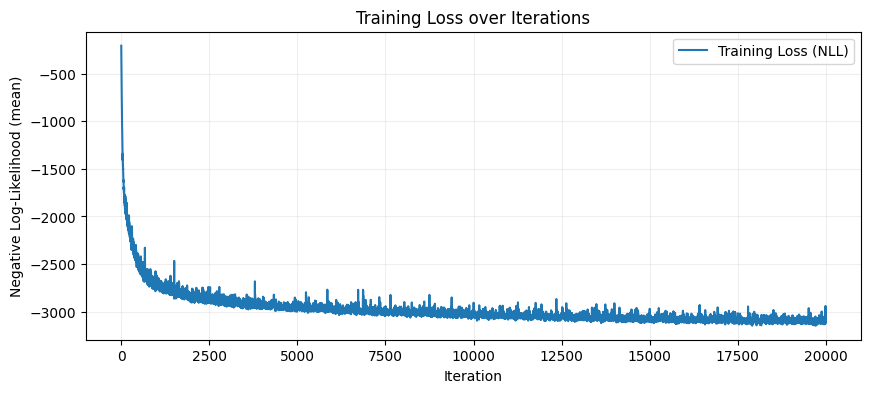

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(loss_hist, label='Training Loss (NLL)')
plt.xlabel('Iteration')
plt.ylabel('Negative Log-Likelihood (mean)')
plt.legend()
plt.title('Training Loss over Iterations')
plt.grid(alpha=0.2)
plt.show()

## Evaluation

To evaluate our model, we first draw samples from our model. When sampling, we can specify the classes, so we draw the samples from each class.

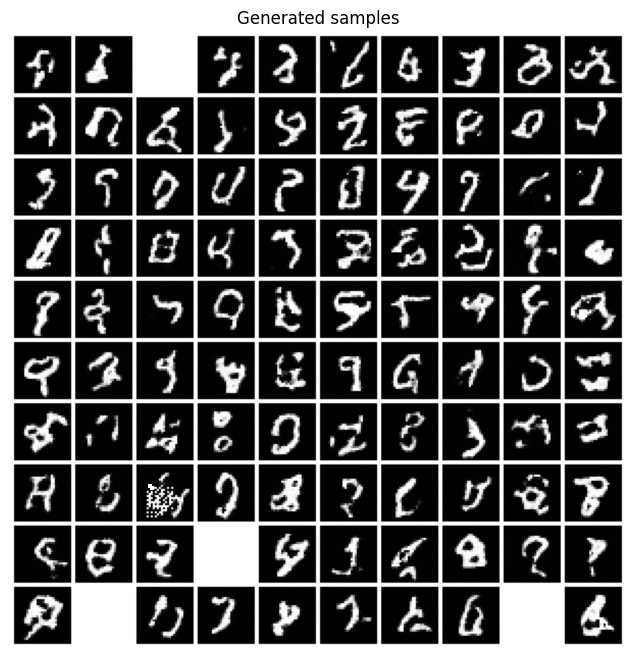

In [ ]:
num_samples_per_row = 10
n_samples = num_samples_per_row ** 2

model.eval()
with torch.no_grad():
    x_samples, _ = model.sample(n_samples)  # probably returns tensor in same scale as inputs
    x_clamped = torch.clamp(x_samples, 0.0, 1.0)  # if transform expects [0,1] display
    grid = tv.utils.make_grid(x_clamped.cpu(), nrow=num_samples_per_row, pad_value=1.0)

plt.figure(figsize=(8, 8))
# if single-channel, squeeze channel axis into colormap
if grid.shape[0] == 1:
    plt.imshow(grid.squeeze(0), cmap='gray')
else:
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title('Generated samples')
plt.show()

Note that to get competitive performance, a much larger model then specified in this notebook, which is trained over more iterations, is needed.

## In-Painting

In [ ]:
#@title Inpainting utilities

def apply_random_square_mask(image, mask_size=8):
    """
    Apply a random square mask to an image.

    Args:
        image: Tensor [C,H,W], C=1 or 3
        mask_size: size of the square mask

    Returns:
        masked_image: same shape as input
        mask: [H,W] binary tensor (1 = masked)
    """
    C, H, W = image.shape
    assert C == 1 or C == 3

    # TODO: create masked_image as a clone of image
    masked_image = image.clone()

    # TODO: create mask tensor of zeros with shape [H,W]
    mask = torch.zeros((H, W), dtype=torch.float32)

    # TODO: randomly select top-left corner of square mask
    # HINT: use np.random.randint(0, H - mask_size + 1)
    h_start = np.random.randint(0, H - mask_size + 1)
    w_start = np.random.randint(0, W - mask_size + 1)

    # TODO: set pixels in the square region to 0 in masked_image
    masked_image[:, h_start:h_start+mask_size, w_start:w_start+mask_size] = 0.0

    # TODO: set corresponding region to 1 in mask
    mask[h_start:h_start+mask_size, w_start:w_start+mask_size] = 1.0

    return masked_image, mask


def apply_random_noise_mask(image, noise_fraction=0.2):
    """
    Apply a random noise mask to an image.

    Args:
        image: Tensor [C,H,W]
        noise_fraction: fraction of pixels to mask with noise

    Returns:
        masked_image: same shape as input
        mask: [H,W] binary tensor (1 = masked)
    """
    C, H, W = image.shape
    masked_image = image.clone()

    mask = torch.zeros((H, W), dtype=torch.float32)

    num_pixels = H * W
    num_noise = int(noise_fraction * num_pixels)

    flat_indices = np.random.choice(num_pixels, num_noise, replace=False)

    ys, xs = np.unravel_index(flat_indices, (H, W))

    noise = torch.FloatTensor(C, num_noise).uniform_(-1, 1).to(image.device)
    masked_image[:, ys, xs] = noise

    mask[ys, xs] = 1.0

    return masked_image, mask


def visualize_masking(original_image, masked_image, mask, title="Masking Example"):
    """
    Accepts tensors [C,H,W] (C maybe 1)
    """
    orig = original_image.squeeze().cpu().numpy()
    masked = masked_image.squeeze().cpu().numpy()
    mask_np = mask.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(orig, cmap='gray')
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(masked, cmap='gray')
    axs[1].set_title("Masked")
    axs[1].axis('off')

    axs[2].imshow(mask_np, cmap='gray')
    axs[2].set_title("Mask")
    axs[2].axis('off')

    plt.suptitle(title)
    plt.show()


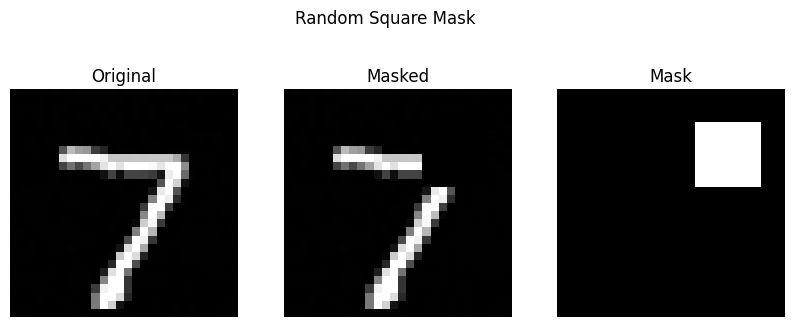

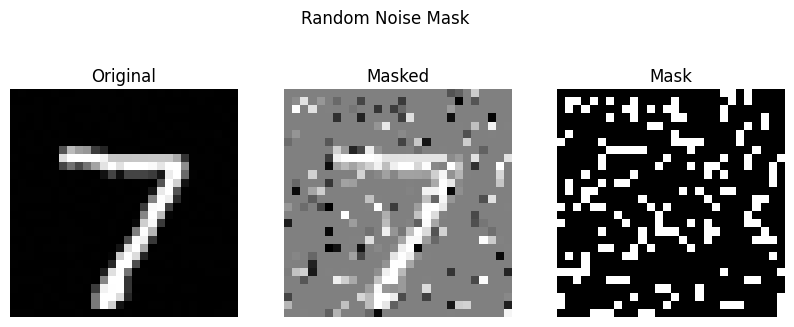

In [ ]:
# Example single image from test set
sample_batch = next(iter(test_loader))
sample_image = sample_batch[0][0]  # first sample, shape [C,H,W]

masked_image_sq, mask_sq = apply_random_square_mask(sample_image, mask_size=8)
visualize_masking(sample_image, masked_image_sq, mask_sq, title="Random Square Mask")

masked_image_n, mask_n = apply_random_noise_mask(sample_image, noise_fraction=0.2)
visualize_masking(sample_image, masked_image_n, mask_n, title="Random Noise Mask")

In [ ]:
def inpaint_image(model, masked_image, mask, device,
                  num_steps=200, lr=0.01, verbose=True):
    """
    Inpaint a single image using a trained flow model via latent/input optimization.
    """
    model.eval()
    masked_image = masked_image.to(device)
    mask = mask.to(device)
    delta = torch.rand_like(masked_image, device=device, requires_grad=True)


    optimizer = torch.optim.Adam([delta], lr=lr)

    iterator = range(num_steps)
    if verbose:
        iterator = tqdm(iterator, desc="Inpainting")

    for step in iterator:
        optimizer.zero_grad()


        full_image = masked_image * (1 - mask) + delta * mask

        input_batch = full_image.unsqueeze(0)

        loss = model.forward_kld(input_batch).mean()

        if torch.isfinite(loss):
            loss.backward()
            optimizer.step()
        else:
            if verbose: print(f"Warning: Non-finite loss at step {step}")
            break

        with torch.no_grad():
            delta.clamp_(0.0, 1.0)

        if verbose:
            iterator.set_postfix({'nll': f'{loss.item():.2f}'})

    with torch.no_grad():
        final_image = masked_image * (1 - mask) + delta * mask

    return final_image.cpu()


def inpaint_batch(model, masked_images, masks, device, num_steps=200, lr=0.01):
    """
    Wrapper to run inpaint_image on a batch.
    """
    model.eval()
    inpainted_list = []

    N = masked_images.shape[0]
    for i in range(N):
        img = masked_images[i]
        msk = masks[i]

        res = inpaint_image(model, img, msk, device, num_steps=num_steps, lr=lr, verbose=False)
        inpainted_list.append(res)

        print(f"Inpainted image {i+1}/{N}")

    inpainted_images = torch.stack(inpainted_list)
    return inpainted_images

In [ ]:
model = model.to(device)
model.eval()

# take a small batch
batch_images, _ = next(iter(test_loader))
batch_images = batch_images[:4]  # N=4
masked_imgs = []
masks = []
for img in batch_images:
    mimg, m = apply_random_square_mask(img, mask_size=8)
    masked_imgs.append(mimg)
    masks.append(m)
masked_imgs = torch.stack(masked_imgs)
masks = torch.stack(masks)

# Run inpainting (note: might be slow; lower num_steps to test)
inpainted = inpaint_batch(model, masked_imgs, masks, device, num_steps=2000, lr=0.01)

Inpainted image 1/4
Inpainted image 2/4
Inpainted image 3/4
Inpainted image 4/4


**NOTE**: Actually getting good in-paintings requires a bigger model. So your score will be determined based on your codes logic and and your outputs being without logic/code bugs.

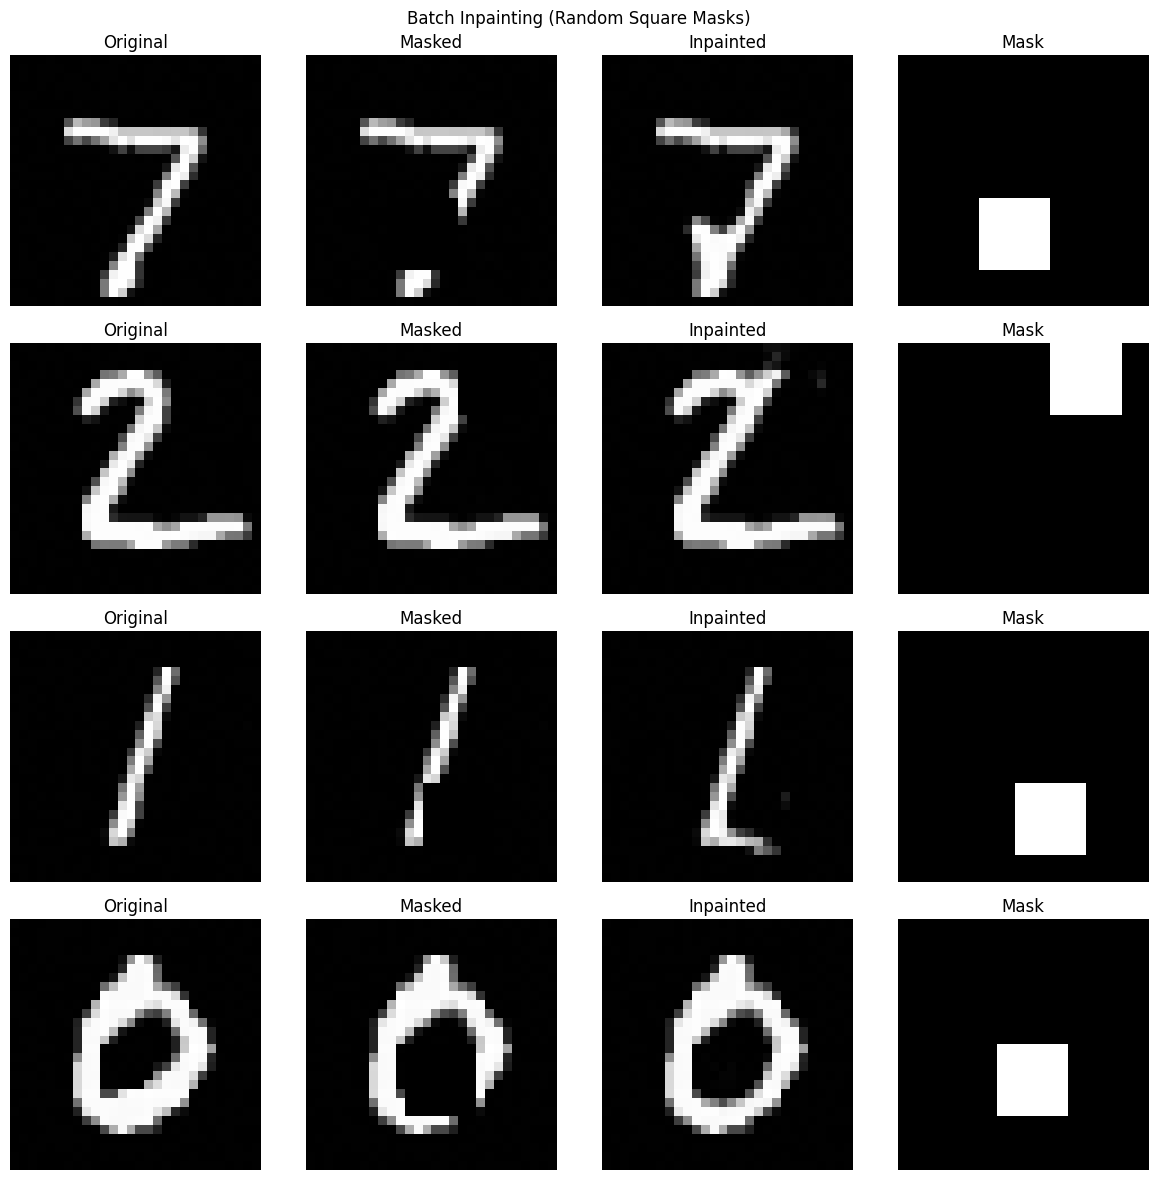

In [29]:
def visualize_batch_inpainting(originals, masked, inpainted, masks, title="Batch Inpainting Results"):
    N = originals.size(0)
    fig, axs = plt.subplots(N, 4, figsize=(12, 3 * N))
    for i in range(N):
        orig = originals[i].squeeze().cpu().numpy()
        maskd = masked[i].squeeze().cpu().numpy()
        inp = inpainted[i].squeeze().cpu().numpy()
        m = masks[i].cpu().numpy()

        axs[i,0].imshow(orig, cmap='gray'); axs[i,0].set_title('Original'); axs[i,0].axis('off')
        axs[i,1].imshow(maskd, cmap='gray'); axs[i,1].set_title('Masked'); axs[i,1].axis('off')
        axs[i,2].imshow(inp, cmap='gray'); axs[i,2].set_title('Inpainted'); axs[i,2].axis('off')
        axs[i,3].imshow(m, cmap='gray'); axs[i,3].set_title('Mask'); axs[i,3].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_batch_inpainting(batch_images, masked_imgs, inpainted, masks, title="Batch Inpainting (Random Square Masks)")